# Modeling BTC

## Import Librari

In [1]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from tqdm import tqdm_notebook as tqdm
import _pickle as pickle
plt.style.use('ggplot')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Format Data

In [2]:
bc = pd.read_csv('BTC-USD.csv')
bc.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
361,2022-04-09,42282.078125,42786.816406,42183.253906,42782.136719,42782.136719,16050772496
362,2022-04-10,42781.089844,43376.378906,42021.207031,42207.671875,42207.671875,17654475582
363,2022-04-11,42201.039063,42424.589844,39373.058594,39521.902344,39521.902344,33949912166
364,2022-04-12,39533.714844,40617.585938,39388.328125,40127.183594,40127.183594,30991500854
365,2022-04-13,40092.164063,41412.605469,39714.687500,41167.367188,41167.367188,28070602752


### Konvert dan Format date

In [3]:
bc['Date'] = pd.to_datetime(bc.Date)
bc.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

#### Date jadi index

In [4]:
bc.set_index('Date', inplace=True)
bc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-13,59890.019531,63742.285156,59869.957031,63503.457031,63503.457031,69983454362
2021-04-14,63523.753906,64863.097656,61554.796875,63109.695313,63109.695313,77451779687
2021-04-15,63075.195313,63821.671875,62208.964844,63314.011719,63314.011719,60954381579
2021-04-16,63258.503906,63594.722656,60222.531250,61572.789063,61572.789063,84293007468
2021-04-17,61529.921875,62572.175781,60361.351563,60683.820313,60683.820313,66138759198


In [8]:
bc = bc[['Close']].loc['2021-04-13':]
bc.head()

,Close
Date,
2021-04-13,63503.457031
2021-04-14,63109.695313
2021-04-15,63314.011719
2021-04-16,61572.789063
2021-04-17,60683.820313


### Export data

In [9]:
with open("curr_bitcoin.pickle", 'wb') as fp:
    pickle.dump(bc, fp)

## Plot Harga

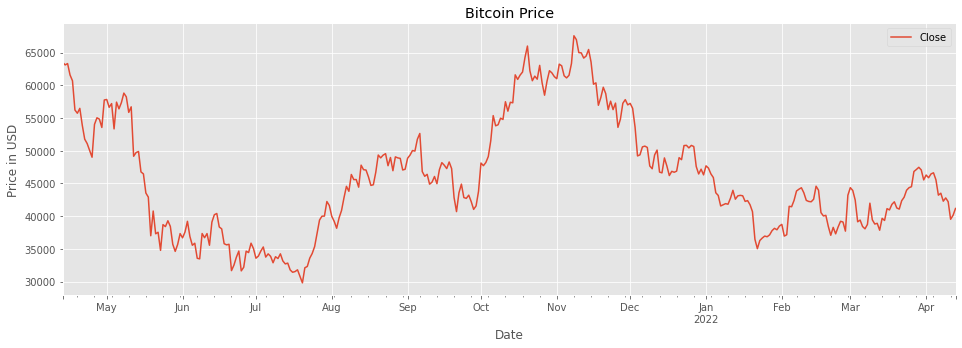

In [10]:
bc.plot(figsize=(16,5))

plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Bitcoin Price')
plt.savefig('btcprice.png')
plt.show()

## Detrending

### Method #1 - Differencing the Data

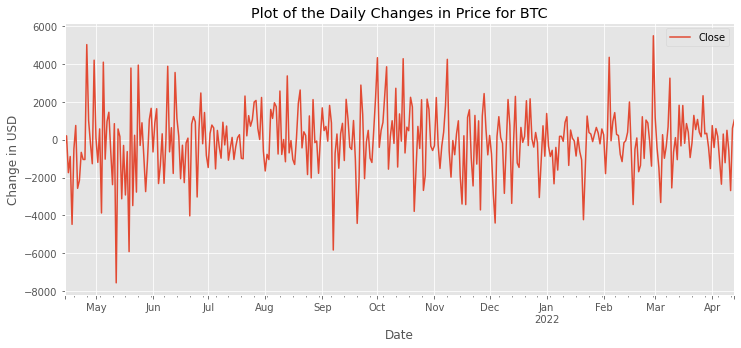

In [11]:
# Differencing the price
bc_diff = bc.diff(1).dropna()

# Plotting the differences daily
bc_diff.plot(figsize=(12,5))
plt.title('Plot of the Daily Changes in Price for BTC')
plt.ylabel('Change in USD')
plt.show()

#### Testing for Stationarity

In [12]:
results = adfuller(bc_diff.Close)
print(f"P-value: {results[1]}")

P-value: 0.0


### Method #2 - Taking the Log then differencing

In [13]:
# Converting the data to a logarithmic scale
bc_log = pd.DataFrame(np.log(bc.Close))

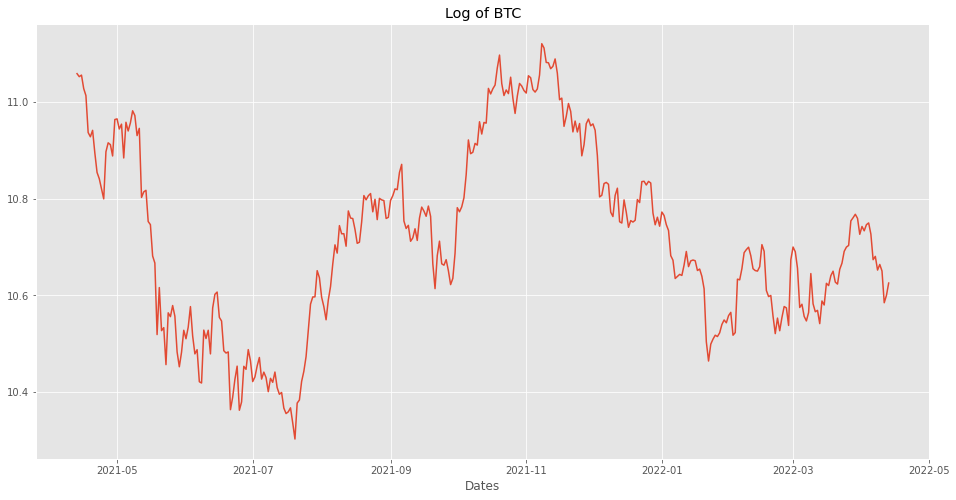

In [14]:
# Plotting the log of the data
plt.figure(figsize=(16,8))
plt.plot(bc_log)

plt.title('Log of BTC')
plt.xlabel('Dates')

plt.savefig('btc_log.png')
plt.show()

In [15]:
# Differencing the log values
log_diff = bc_log.diff().dropna()

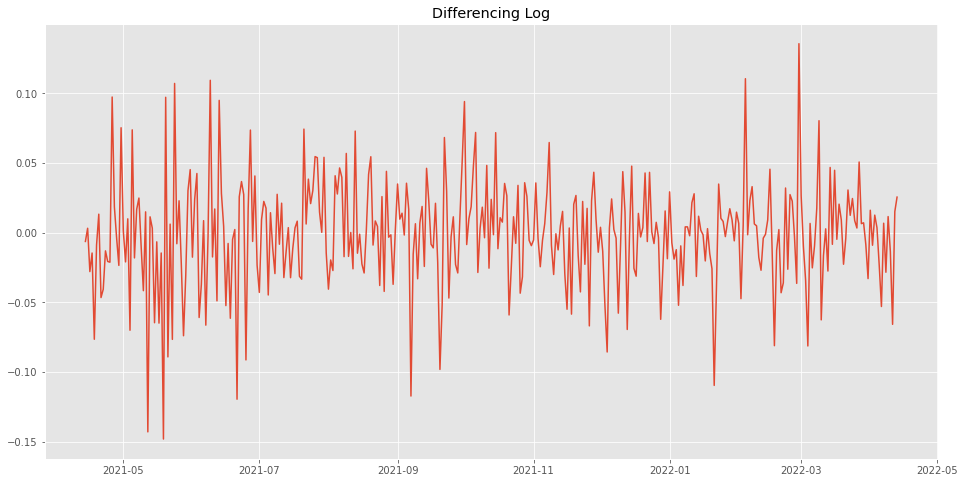

In [16]:
# Plotting the daily log difference
plt.figure(figsize=(16,8))
plt.plot(log_diff)
plt.title('Differencing Log')
plt.savefig('logdiff.png')
plt.show()

#### Testing for Stationarity

In [17]:
results = adfuller(log_diff.Close)
print(f"P-value: {results[1]}")

P-value: 0.0


## PACF dan ACF

#### ACF & PACF untuk Differencing

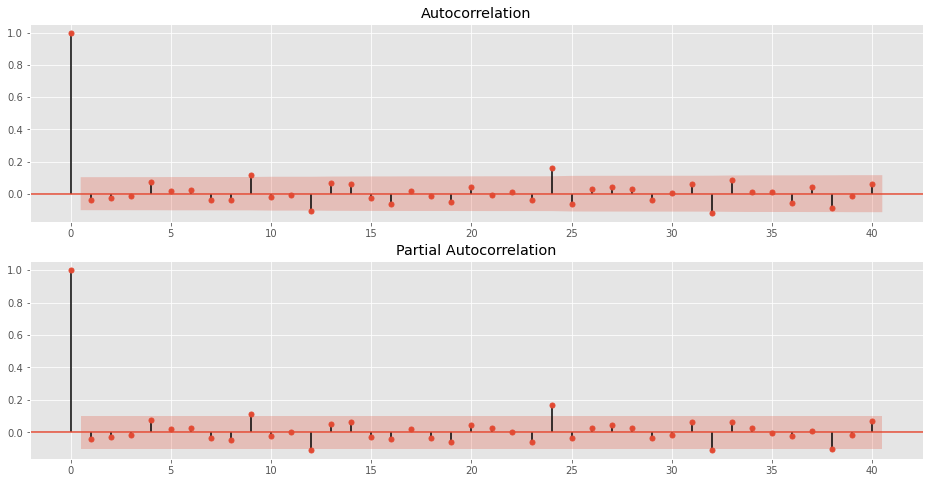

In [18]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
plot_acf(bc_diff, ax=ax1, lags=40)
plot_pacf(bc_diff, ax=ax2, lags=40)
plt.show()

#### ACF and PACF for the Log Difference

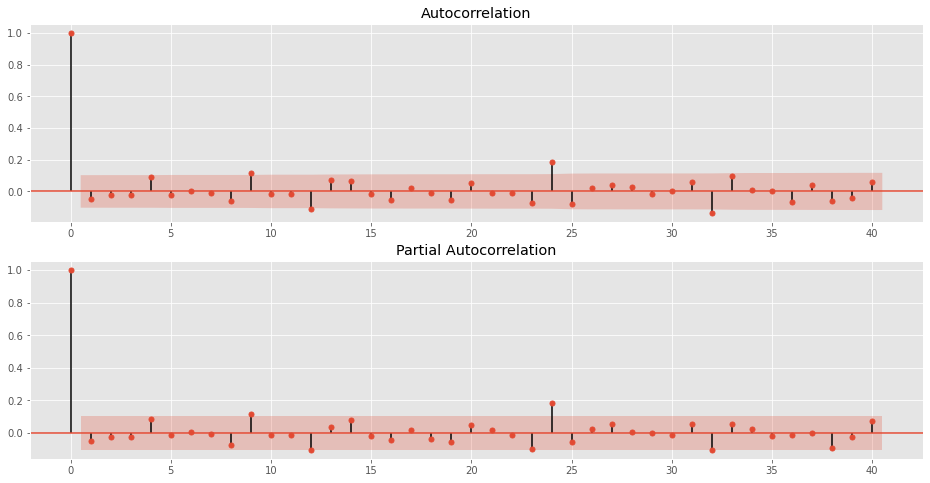

In [19]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
plot_acf(log_diff, ax=ax1, lags=40)
plot_pacf(log_diff, ax=ax2, lags=40)
plt.savefig('acfpacf.png')
plt.show()

## Modeling

## SARIMA Model for Differencing

### Cari Parameter ARIMA

In [20]:
def best_param(model, data, pdq, pdqs):
    """
    Loops through each possible combo for pdq and pdqs
    Runs the model for each combo
    Retrieves the model with lowest AIC score
    """
    ans = []
    for comb in tqdm(pdq):
        for combs in tqdm(pdqs):
            try:
                mod = model(data,
                            order=comb,
                            seasonal_order=combs,
                            enforce_stationarity=False,
                            enforce_invertibility=False,
                            freq='D')

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    return ans_df.loc[ans_df.aic.idxmin()]

In [21]:
# Assigning variables for p, d, q.
p = d = q = range(0,6)
d = range(2)

# Creating a list of all possible combinations of p, d, and q.
pdq = list(itertools.product(p, d, q))

# Keeping seasonality at zeroes
pdqs = [(0,0,0,0)]


In [22]:
# Finding the best parameters
best_param(SARIMAX, bc_log, pdq, pdqs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq        (1, 0, 0)
pdqs    (0, 0, 0, 0)
aic     -1334.984674
Name: 12, dtype: object

#### Parameter terbaik

In [ ]:
# pdq        (1, 0, 0)
# pdqs    (0, 0, 0, 0)
# aic         -3368.06

### Fitting & Training SARIMAX

#### Train, test, split

In [23]:
# Splitting 80/20
index = round(len(bc)*.80)

train = bc_log.iloc[:index]
test = bc_log.iloc[index:]

In [24]:
# Fitting the model to the training set
model = SARIMAX(train, 
                order=(1, 0, 0), 
                seasonal_order=(0,0,0,0), 
                freq='D', 
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = model.fit()

### Analisis fitting model

                           Statespace Model Results                           
Dep. Variable:                  Close   No. Observations:                  293
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 531.020
Date:                Thu, 14 Apr 2022   AIC                          -1058.040
Time:                        05:48:59   BIC                          -1050.687
Sample:                    04-13-2021   HQIC                         -1055.094
                         - 01-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.000   4583.385      0.000       0.999       1.000
sigma2         0.0015   9.89e-05     15.581      0.000       0.001       0.002
Ljung-Box (Q):                       73.30   Jarque-

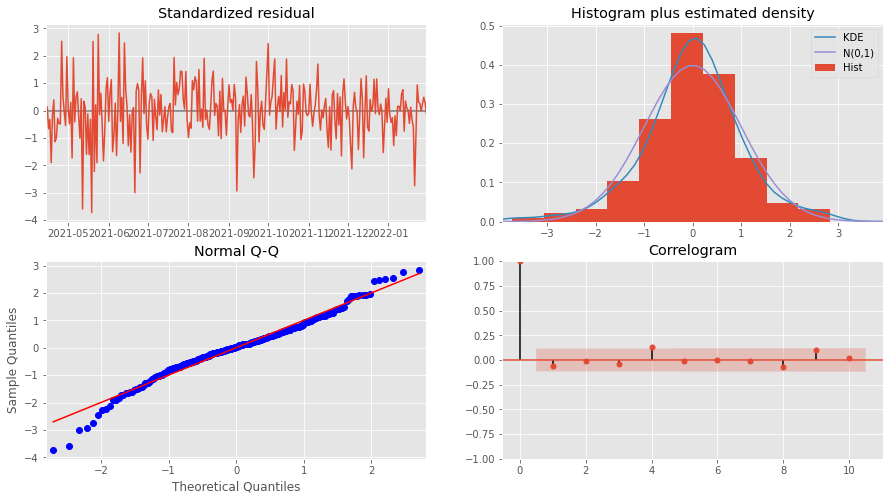

In [25]:
print(output.summary())
output.plot_diagnostics(figsize=(15,8))
plt.show()

### Ubah ke harga asli

In [27]:
# Values to test against the test set
fc   = output.get_forecast(len(test))
conf = fc.conf_int()

# Transforming the values back to normal
fc_series    = np.exp(pd.Series(fc.predicted_mean, index=test.index))
lower_series = np.exp(pd.Series(conf.iloc[:, 0], index=test.index))
upper_series = np.exp(pd.Series(conf.iloc[:, 1], index=test.index))

etrain = np.exp(train)
etest  = np.exp(test)

# Values to test against the train set, see how the model fits
predictions = output.get_prediction(start=pd.to_datetime('2018'), dynamic=False)
pred        = np.exp(predictions.predicted_mean)

# Confidence interval for the training set
conf_int   = np.exp(predictions.conf_int())
low_conf   = np.exp(pd.Series(conf_int.iloc[:,0], index=train.index))
upper_conf = np.exp(pd.Series(conf_int.iloc[:,1], index=train.index))



KeyError: ignored

### Plot Flitted Model

NameError: ignored

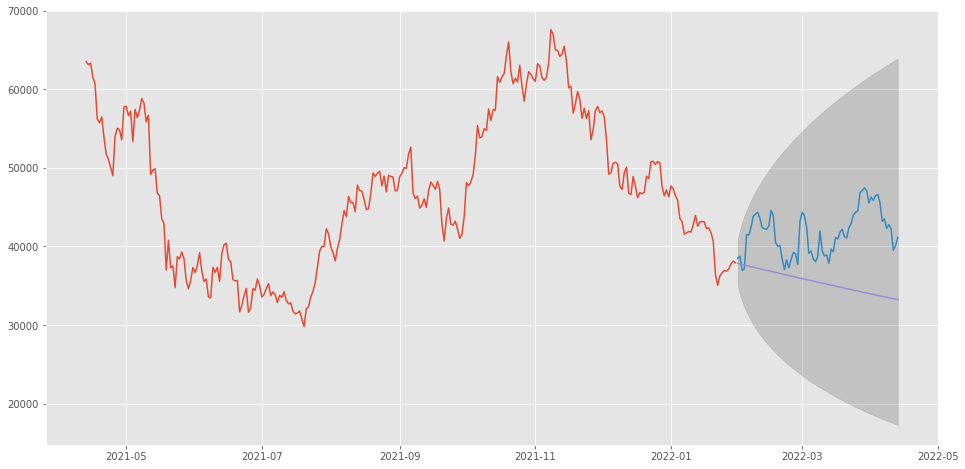

In [28]:
rcParams['figure.figsize'] = 16, 8

# Plotting the training set, test set,forecast, and confidence interval.
plt.plot(etrain, label='train')
plt.plot(etest, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

# Plotting against the training data
pred.plot(label='Fit to Training', color='w')

# Confidence interval for the fitted data
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='g',alpha=.5)

# Limiting the viewing size
plt.xlim(['2018-06', '2019-10'])
plt.ylim([0, 20000])

plt.title('Fit to Train Data and \nForecasting vs Actual Test Values')
plt.legend()
plt.savefig('btc_fit_fc.png')
plt.show()

### Menghitung RMSE untuk SARIMA

In [ ]:
forecast = pred
actual_val = etrain.Close

# Calculating our errors
rmse = np.sqrt(((forecast - actual_val) ** 2).mean())

print("The Root Mean Squared Error: ", rmse)

The Root Mean Squared Error:  358.9843097214424


### Forecasting Future Values

#### Fitting model

In [ ]:
model = SARIMAX(bc_log, 
                order=(1, 0, 0), 
                seasonal_order=(0,0,0,0), 
                freq='D', 
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = model.fit()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


In [ ]:
# Getting the forecast of future values
future = output.get_forecast(steps=30)

# Transforming values back
pred_fut = np.exp(future.predicted_mean)

# Confidence interval for our forecasted values
pred_conf = future.conf_int()

# Transforming value back
pred_conf = np.exp(pred_conf)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


### Plotting nilai forecasted

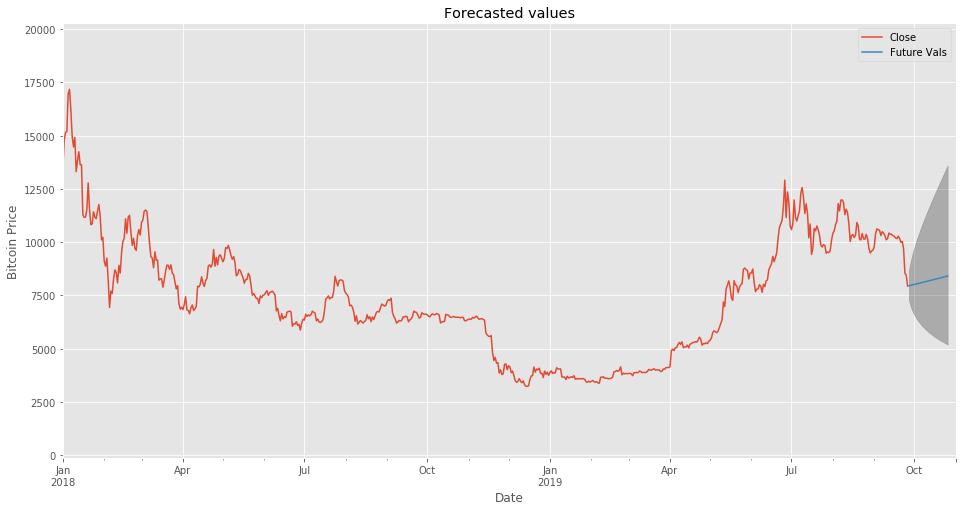

In [ ]:
# Plotting the prices up to the most recent
ax = np.exp(bc_log).plot(label='Actual', figsize=(16,8))

# Plottting the forecast
pred_fut.plot(ax=ax, label='Future Vals')

# Shading in the confidence interval
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin Price')
ax.set_xlim(['2018-01', '2019-11'])

plt.title('Forecasted values')
plt.legend()
plt.savefig('fc_val.png')
plt.show()

### Perbesar Plot

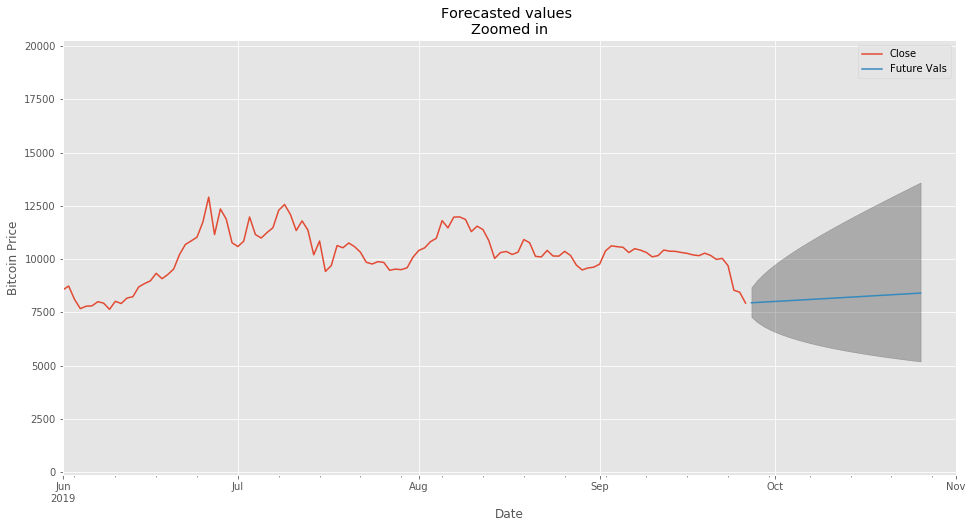

In [ ]:
ax = np.exp(bc_log).plot(label='Actual', figsize=(16,8))
pred_fut.plot(ax=ax, label='Future Vals')

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin Price')
ax.set_xlim(['2019-06','2019-11'])

plt.title('Forecasted values \nZoomed in')
plt.legend()
plt.savefig('fc_zoom.png')
plt.show()